In [12]:

%pylab inline
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


$R_x = R_{xf} + R_{xr} = f_r(W_f+W_r) = f_rW\ $

In [2]:
vmaxtot=106/3.6; #Velocidad máxima alcanzable (m/s) reportado por Clavijo

In [3]:
I=52 #kg*cm2

In [25]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión
NGS=[1.1333,1.3852,1.637,1.8889,2.1407,2.3926,2.6444,2.8963,3.1481,3.4] #Realciones de transmision obtenidas de ilustracion 45 de clavijo

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)


# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

masa_eq = 200 # ESto toca calcularlo correctamente

gamma = 1 # aceleracion
deltat=0.005
mu=0.85 #coeficiente de friccion

Fuerzas

In [15]:
def peso(m):
    pes=m*g
    return pes

def frodadura(m,vx,theta):
    z=(a/l)*peso(m) #constante de rodadura
    mr=peso(m)*((1/g*(h/l))) # masa de rodadura
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)

    return mr*fr*cos(theta) , z*fr*cos(theta) # (N)

# Fuerza del ángulo de la carretera
def finclinacion(m,theta):
    return peso(m)*sin(theta) # (N)

# Fuerza de arrastre
def farrastre(vx):
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)


def torque_curva(omega_m):
    om=np.array((60*omega_m/(2*pi)))
    om[om>5000]=5000
    P=3.037*((-0.00000004564538677*om**3)+(0.0001056995459*om**2)+(1.53209191*om)-1.895523696)
    T=P/(om*2*pi/60)
    return T

#modelo de frenado similar al modelo de rodadura
def Ffrenado(m,v,theta,mu):

    mr=peso(m)*((1/g*(h/l))) # masa de rodadura
    z=(a/l)*peso(m) #constante de rodadura
    fr=mu*cos(theta)
    return mr*fr , z*fr # (N)


In [6]:
# Velocidad angular del motor
def vangularmotor(vx):
    return (vx*ng)/(refc*etaf) # (rad/s)

Inicio arranque

In [7]:
def dveldt(velv,t_in,ng,m):
    xx,vel = velv
    ax=0
    frod = frodadura(m,vel,theta)[1]
    farr = farrastre(vel)
    fincli = finclinacion(m,theta)
    return [vel,(torque_curva(vangularmotor(vel))*ng*etaf/refc-frod-farr-fincli)/masa_eq] # para solucionar
    # al tiempo posición y velocidad

def ArranqueSolucion(t_in,c_ini,ng,m):
    t=np.arange(t_in,t_in+3,deltat)
    sol = odeint(dveldt, c_ini, t,args=(ng,m))
    ultimo=sol[-1,1]
    penultimo=sol[-2,1]
    if ultimo-penultimo>0.0001:
        sol=concatenate((sol,ArranqueSolucion(t[-1],[sol[-1,0],sol[-1,1]],ng,m)),axis=0)
    return sol
    



Frenado

In [17]:
def dveldtFrenado(v,t_in):
    xx,vel=v
    Mfr=Ffrenado(masa_eq,vel,theta,mu)[0] #Masa del modelo de rodadura
    Cfr=Ffrenado(masa_eq,vel,theta,mu)[1] #Constante del modelo de Rodadura
    farr = farrastre(vel)
    fincli = finclinacion(masa_eq,theta)

    a=(1/(masa_eq+Mfr))*(Cfr-farr-fincli)
    return [vel,a]

def FrenadoSolucion(t_in,c_ini):
    t=np.arange(t_in,t_in+200,deltat)
    sol = odeint(dveldtFrenado, c_ini, t)
    return sol

Analisis

El objetivo de este taller es desarrollar un modelo simplificado de un kart electrico, adicionalmente se realizaron simulaciones de arrancado hasta llegar a velocidad maxima y posteriormente frenado hasta velocidad 0. Dichas simulaciones se realizaron variando la relacion de transmision, se usaron las siguientes relaciones:

In [9]:
NGS

[1.1333, 1.3852]

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10880000 but corresponding boolean dimension is 54400


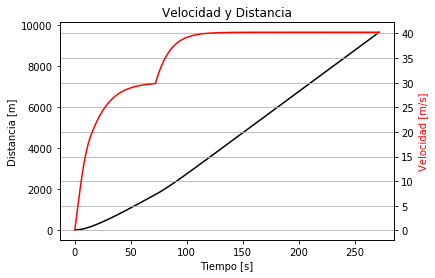

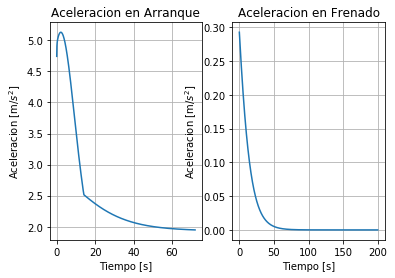

Relación de Transmisión = 1.1333 ;Masa = 152.0 kg ;Velocidad pico = 29.8199812192 m/s ;tiempo total =  271.995  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10760000 but corresponding boolean dimension is 53800


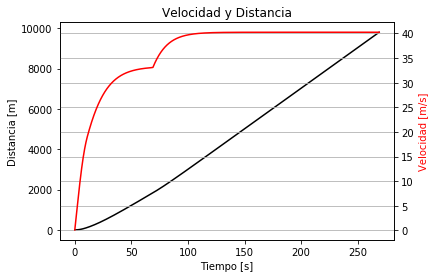

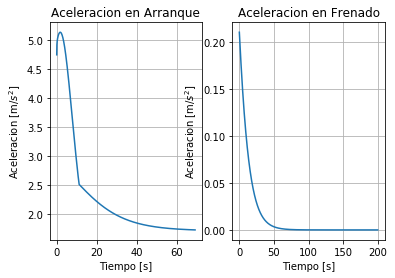

Relación de Transmisión = 1.3852 ;Masa = 152.0 kg ;Velocidad pico = 33.0796897693 m/s ;tiempo total =  268.995  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10640000 but corresponding boolean dimension is 53200


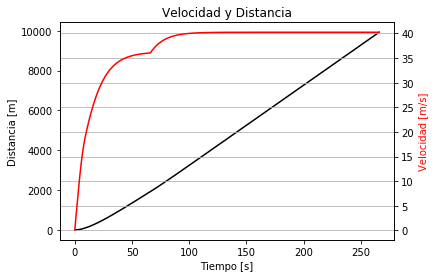

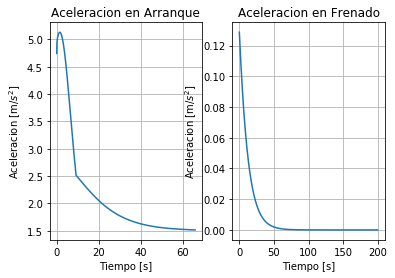

Relación de Transmisión = 1.637 ;Masa = 152.0 kg ;Velocidad pico = 36.0395037171 m/s ;tiempo total =  265.995  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10520000 but corresponding boolean dimension is 52600


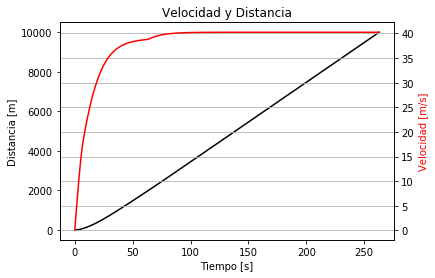

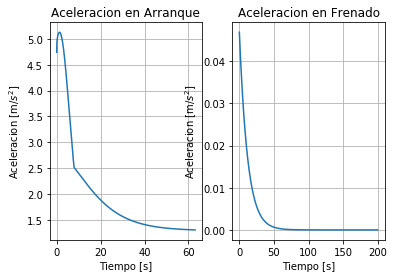

Relación de Transmisión = 1.8889 ;Masa = 152.0 kg ;Velocidad pico = 38.7689458393 m/s ;tiempo total =  262.995  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10400000 but corresponding boolean dimension is 52000


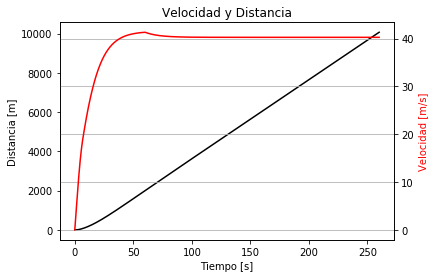

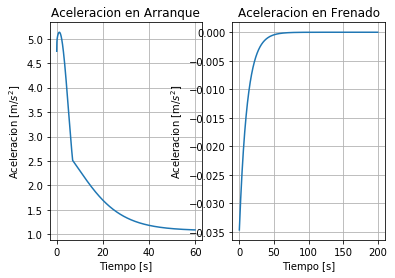

Relación de Transmisión = 2.1407 ;Masa = 152.0 kg ;Velocidad pico = 41.3107025158 m/s ;tiempo total =  259.995  s


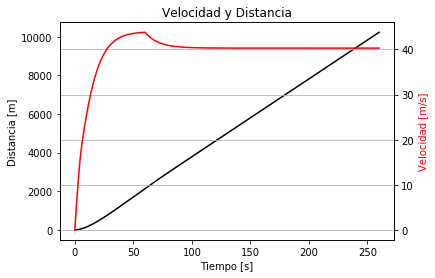

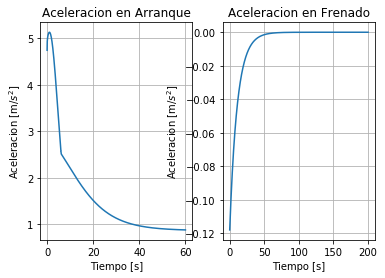

Relación de Transmisión = 2.3926 ;Masa = 152.0 kg ;Velocidad pico = 43.7523988327 m/s ;tiempo total =  259.995  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10280000 but corresponding boolean dimension is 51400


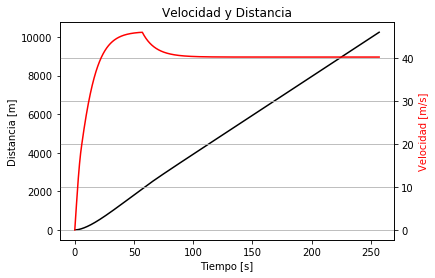

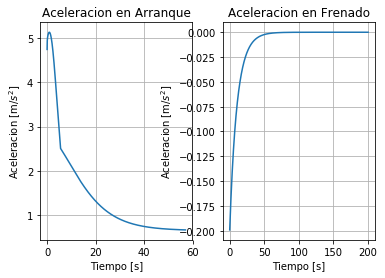

Relación de Transmisión = 2.6444 ;Masa = 152.0 kg ;Velocidad pico = 46.0132321269 m/s ;tiempo total =  256.995  s


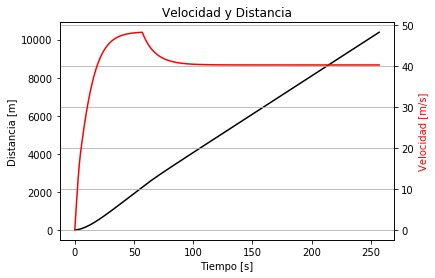

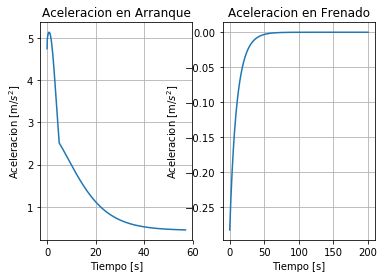

Relación de Transmisión = 2.8963 ;Masa = 152.0 kg ;Velocidad pico = 48.2133356253 m/s ;tiempo total =  256.995  s


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10160000 but corresponding boolean dimension is 50800


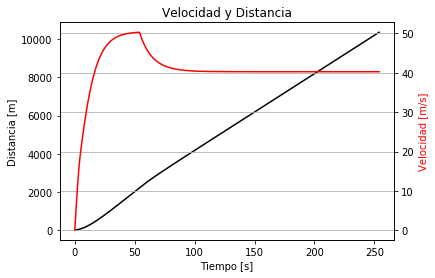

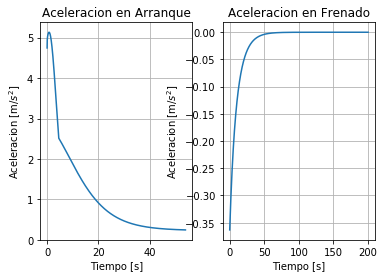

Relación de Transmisión = 3.1481 ;Masa = 152.0 kg ;Velocidad pico = 50.2678743773 m/s ;tiempo total =  253.995  s


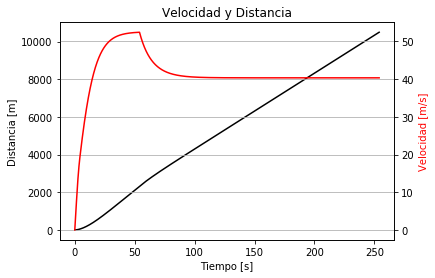

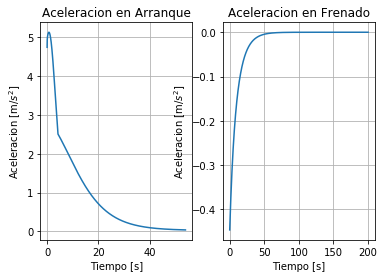

Relación de Transmisión = 3.4 ;Masa = 152.0 kg ;Velocidad pico = 52.2872645151 m/s ;tiempo total =  253.995  s


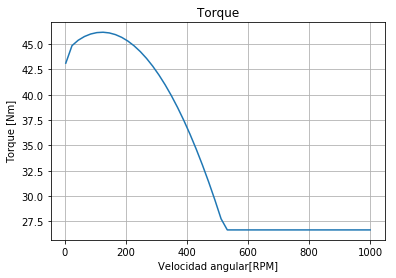

Torque máximo alcanzado = 46.1587634759 Nm


In [26]:
for i in NGS:
    t_in=0
    x_0=0
    v_0=0.1
    c_ini = [x_0,v_0]
    solArranque=ArranqueSolucion(t_in,c_ini,i,masa) #solucion del arranque

    solArranque

    t_inF=0
    x_0F=solArranque[-1,0]
    v_0F=solArranque[-1,1]
    c_iniF = [x_0F,v_0F]#condiciones finales del arranque e iniciales del frenado
    solFrenado=FrenadoSolucion(t_inF,c_iniF) #solucion del frenado

    solTotal=concatenate((solArranque,solFrenado)) 

    acelArran=[]
    for vel in solArranque[:,1]:
        Mrod = frodadura(masa_eq,vel,theta)[1]
        Crod = frodadura(masa_eq,vel,theta)[1]
        farr = farrastre(vel)
        fincli = finclinacion(masa_eq,theta)
        acelArran=append(acelArran,(torque_curva(vangularmotor(vel))*ng*etaf/refc-4*Crod-farr-fincli)/(masa_eq+4*Mrod))
    acelFrena=[]
    for vel in solFrenado[:,1]:
        Mfre = Ffrenado(masa_eq,vel,theta,mu)[1]
        Cfre = Ffrenado(masa_eq,vel,theta,mu)[1]
        farr = farrastre(vel)
        fincli = finclinacion(masa_eq,theta)
        acelFrena=append(acelFrena,(Cfre-farr-fincli)/(masa_eq+Mfre))
    #Frame
    data=pd.DataFrame=({'Tiempo':arange(0,len(solTotal[:,0]),deltat),'Posicion':solTotal[:,0],'Velocidad':solTotal[:,1]})

    #plot
    t=data['Tiempo'][data['Velocidad']>=0]
    posiciones=data['Posicion'][data['Velocidad']>=0]
    velocidades=data['Velocidad'][data['Velocidad']>=0]

    #grafica posicion y velocidad
    fig,aux1=subplots()
    aux2=aux1.twinx()
    aux1.plot(t,posiciones,'k-')
    aux2.plot(t,velocidades,'r-')
    aux1.set_xlabel('Tiempo [s]')
    aux1.set_ylabel('Distancia [m]', color='k')
    aux2.set_ylabel('Velocidad [m/s]', color='r')
    grid()
    title('Velocidad y Distancia')
    plt.show()
    #Acceleration
    subplot(1,2,1)
    plot(t[:len(acelArran)],acelArran)
    grid()
    title('Aceleracion en Arranque')
    xlabel('Tiempo [s]')
    ylabel('Aceleracion [m/$s^2$]')
    subplot(1,2,2)
    plot(t[:len(acelFrena)],acelFrena)
    grid()
    title('Aceleracion en Frenado')
    xlabel('Tiempo [s]')
    ylabel('Aceleracion [m/$s^2$]')
    plt.show()
    print('Relación de Transmisión =',i,';Masa =',masa,'kg ;Velocidad pico =',solArranque[-1,1],'m/s ;tiempo total = ',t[-1],' s')
#Torque
omega=np.linspace(4,1000,50)
T=[]
for w in omega:
    T=np.append(T,torque_curva(w))
plt.plot(omega,T)
plt.grid()
plt.title('Torque')
plt.xlabel('Velocidad angular[RPM]')
plt.ylabel('Torque [Nm]')
plt.show()
print('Torque máximo alcanzado =',max(T),'Nm')
    
  

In [ ]:
def acel(vel,ng):
    xx,vel = velv
    ax=0
    frod = frodadura(vel,ax)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,(torque_curva(vangularmotor(vel))*ng*etaf/refc-frod-farr-fincli)/masa_eq] # para solucionar


In [ ]:
def potencia(omeg, vmax):
    om=(5000*omeg/vmax)
    om[om>5000]=5000
    P=3.037((-0.00000004564538677*om**3)+(0.0001056995459*om**2)+(1.53209191*om)-1.895523696)
    return P

In [ ]:
w=linspace(1,1000,500)
torque=torque_curva(w)
w=w*(60/(2*np.pi))
plot(w,torque,'-g')
plt.xlabel('Velocidad Angular (RPM)')
plt.ylabel('Torque (Nm)')
plt.xlim(0, 5000)
grid(True)

In [ ]:
def graficarPosiYVel(sol,t):
    
    plot(t, sol[:, 0], 'g')
    xlabel('Tiempo (s)')
    ylabel('Distancia (m)',color='g')
    twinx()
    
    v=sol[:,1]
    v[v<0]=0
    plt.plot(t, v*3.6, 'b')
    ylabel('Velocidad (Km/h)',color='b')

    plt.grid()


In [ ]:
graficarPosiYVel(ArranqueSolucion(0,[0,0.1],ng,masa),t)

In [ ]:
def frenado(velv, t0):
    xx, v = velv
    vel=np.array(v)
    ax=0
    vel[vel<0]=0
    Fd = w*mu*(l-a)/l
    Ft = w*mu*(a/l)
    ax=ac[-1]
    Frod = frodadura(vel,ax)
    Farr = farrastre(vel)
    Fincli = finclinacion(theta)
    fren = (-Fd-Ft-Farr-Frod-Fincli)/masa_eq
    if vel<0:
        fren=0
    return vel, fren

In [ ]:
vela

In [ ]:
np.arange()